In [19]:
# DEPENDENCIES
%matplotlib inline
from environment import ENVIRONMENT
from auv import AUV
from visualization import VISUALIZATION
from mission import MISSION
from utils import InspectReefData2D, InspectReefData3D, InspectReefData2DComplete
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from IPython.display import display, HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))
size = 9

# set size of the plot
plt.rcParams['figure.figsize'] = [size, size]

# Energy Efficient Path Planning in Uncertain Environments

# 1.0 Introduction
## 1.1 Motivation 
Science gain on exploration missions is often limited by factors related to the vehicle's endurance. In particular, energy consumption and battery capacity often limit the length of a mission. The demand for more extensive missions calls for an optimization that goes beyond the vehicle itself, by also leveraging the vehicle's environment to achieve maximum efficiency. However, while models about the environment often contain information about obstacles, uncertain/unknown regions, currents, etc. such models are often subject to uncertainty and may ultimately lead to hazards for the vehicle and/or its environment. Therefore, autonomous vehicles need to be able to account for their environment and the uncertainty that is associated with their models. 

## 1.2 Problem Statement
Known for its underwater missions, the Model-Based Embedded and Robotics Systems (MERS) group at MIT is contacted by an ocean research institute (ORI), and is asked to provide robotic support for underwater data collection. More specifically, the ORI wants to conduct several missions in the vicinity of an underwater volcano, in order to learn about when the volcano will erupt next. Besides oceanography, the ORI also engages in research on an endangered sharks species that is quite common in the area around the volcano and wants to conduct a shark observation mission. As the ORI cannot send any humans to these areas and does not have any experience with robotics they need MERS' help.

The MERS group already has an AUV that can perform the required sampling tasks. However, the ORI warns the group that the mission environment is very risky, and contains many obstacles that must be avoided. The ORI also warns that the mission region is prone to strong underwater currents. These currents are strongly dependent on the time of the day. In order to prevent having to fight currents the MERS group decides to conduct the first mission in the early morning, when there is no current. However, the shark observation mission can only be done in the early afternoon as this is the time when the sharks come up from the depths to have themselves cleaned by small cleaner fishes. The currents in the afternoon are known to be strong, steady, unidirectional currents. The ORI gives one final warning that, in the evening, these currents transition into dangerous circular, so-called _whirlpool_ currents.

The MERS group is very excited to be part of the institute's research and starts to think about how to go about planning the missions. Both risk and currents are challenges that the group has not faced before. The group knows that strong currents could greatly affect energy efficiency, so they decide to try and improve their existing path-planning algorithms, so that they can incorporate risk and underwater currents. Please see the two missions visualized below:

![](mission1&2.png) <br>

## 1.3 Outline
In this problem set we will develop a set of path planning algorithms which take into account risk as well as ocean currents for energy-efficient path planning in uncertain environments. First, we will introduce two path-planning algorithms, demonstrate their behavior, and discuss their advantages and disadvantages. Second, we will introduce an autonomous underwater exploration mission and describe how we model the environment, the AUV, and the mission parameters. Then, the environmental model will be extended to incorporate risk (e.g. due to obstacles), as well as a model of ocean currents. Finally, we will discuss how to incorporate uncertainty in both the risk and current models using this framework. Along the way, we will demonstrate the path planning algorithms by applying them to a selection of mission scenarios with varying risks and ocean currents (see figures below). We will also analyze and compare the performance of each path planning algorithm with respect to the vehicle's energy savings.

<table><tr><td><div style="width:image width px; font-size:100%; text-align:center;"><img src='current_uniformx.png' />Uniform current in x-direction.</div></td><td<div style="width:image width px; font-size:100%; text-align:center;"><img src='current_uniformy.png' />Uniform current in y-direction.</div></td><td><div style="width:image width px; font-size:100%; text-align:center;"><img src='current_circular.png' />Circular current.</div></td></tr></table>

# 2.0 Introduction to AUV path-planning

## 2.1 Introduction to the basic path-planning algorithms
The two algorithms we will be utilizing are A\* and Dijkstra's. A\* is known as a "best-first" search algorithm. The idea is to use the heuristic cost, along with distance, in order to decide the order of the nodes in the priority queue. For each current node, we place the neighbors in a priority queue and compute their heuristic cost through the current node. We then extend the neighbor that has the least cost and repeat this process until the goal node is reached. More information can be found on [this page](https://en.wikipedia.org/wiki/A*_search_algorithm).

Dijkstra's algorithm is a shortest path finder. Similarly to A\*, we look at the neighbors of the current node and compute the distances to each neighbor through the current node. If a computed distance is shorter than the shortest distance currently recorded in that neighbor, their shortest distance is updated. Then, the current node is set to the neighbor with the smallest distance. This continues until the goal node is reached. More information can be found on [this page](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm).


## 2.2 Implementing a path cost function

To warm up, we are going to implement a cost function that will compute the path cost between two points in space (nodes in the search graph). In this application, we will define the cost in terms of the **time** it takes the AUV to traverse from one node to another. To help you, we have defined a few helper functions that you may use in your cost function:

In [21]:
def dist(node1, node2):
    return ((node1.position[0] - node2.position[0]) ** 2) + ((node1.position[1] - node2.position[1]) ** 2)

def computeunitvector(node1, node2):
    # Unit vector pointing from node1 to node2
    s = np.array(node2.position)-np.array(node1.position)
    s = s[0:2].flatten()
    ns = np.linalg.norm(s)
    if ns < 1e-10:
        return (0, np.array((0,0)))
    s = s/ns
    return s

Using these helper functions, fill in the function below so that it returns the cost (traversal time) between the  two nodes, as well as a 2D vector, V_AUV, which defines the velocity of the AUV as it leaves node1 (heading toward node2).

In [22]:
from costfunctions import *
## student implements function "cost"

In the case of the A* algorithm, we also need to implement a function that computes the cost-to-go from a given node. For now, the cost-to-go function can simply be the time required to traverse in a straight line from the given node to the goal.

In [23]:
## student implements function "heuristic"

## 2.2 Testing the algorithms in a simple environment

After learning about the dangerous circumstances in the mission region (obstacles, wild currents during parts of the day) the MERS group is worried whether the algorithms they have so far will make sure they do not lose their vehicle on one of the missions. Therefore, the group decides to do some testing in a swimming pool before they dedicate themselves to the real mission. The pool they have available is $100$ meters long, $100$ meters wide, and 10 meters deep. 

Let's now define the "swimming pool" test mission for our AUV. Our exploration area is $100\text{m}$ x $100\text{m}$ we set `worldsize_x = 100` and `worldsize_y = 100`. The bathymetry data we are given has a resolution of $1\text{m}$, so we specify the distance between two nodes in our exploration area as $1\text{m}$ by passing `discretization_distance = 1` to the class init function call (see file `mission.py`):

In [3]:
# define underwater exploration mission
UEXP = MISSION(discretization_distance=1, worldsize_x=100, worldsize_y=100)

Next, we define the underwater environment. We use the `ENVIRONMENT` class provided in `environment.py` which expects an argument for the mission that it is mapped to and an argument that specifies the function that describes the reefs surface. The mission that the environment is mapped to is our mission `UEXP`. The depth of the reef has already been programmed as a default in the environment class, so we do not have to provide a reef function (hence we provide `reef function=None`):

In [4]:
ENV1 = ENVIRONMENT(UEXP, ReefFunction= "pool")

Now that the mission and the environment for our pool test case are modelled, we need to define the AUV we want to use. With the class `AUV` (see file `auv.py` in this folder) we create an instance and set the mission of the AUV via the `setattr` function. We then specify the AUV's start point (`origin`) as $(x,y,z) = (60,10,-9.5)$, and its goal by `AUV1.goal = (61,50,-9.5)`. We set the vehicle's speed to $2\text{ m/s}$.

In [5]:
# define autonomous underwater vehicle & assign vehicle parameters
AUV1 = AUV()

# allocate vehicle to a mission
setattr(AUV1, 'mission', UEXP)

# set vehicle parameters
AUV1.origin = (50, 50, -9.5)
AUV1.goal = (80, 50,-9.5)
AUV1.speed = 2

Finally, we can proceed to the actual planning. Before running the planner though, as we want to visualize our planning result, we create a visualization object using the provided `VISUALIZATION` class (see file `visualization.py`). Creating such an object is easy as we just have to create the object by passing the environment and the AUV that we want to visualize. In the visualization the origin of our AUV will show up as a black point while the goal of our AUV will be represented by a green star.

After defining the visualization object we only need to call the path planner method `.PlanPath` with an argument that specifies the algorithm we want it to use (`alg=A*`), the environment we want to do the path planning for (`env=ENV1`), the visualization parameter (`vis=None`), and the alpha parameter (`alpha=0`). Then we just let the vehicle explore on its path, save the visualization of the exploration to the visualization object's attribute `.video`, and display it as an HTML:

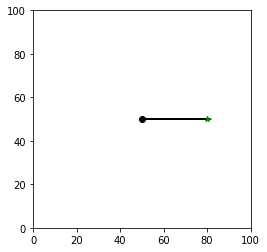

In [6]:
# define our visualization output & create it
VIS1 = VISUALIZATION(AUV1,ENV1)
VIS1.ShowReef()

# plan path for the pool test environment
AUV1.PlanPath(alg = "A*", cost = cost, heuristic = heuristic, env = ENV1, vis=None, alpha=0)
VIS1.video = VIS1.Explore()
HTML(VIS1.video.to_html5_video())

Just as we did above we perform the same steps again for the Dijkstra algorithm:

Cost map generated!
goal is found!


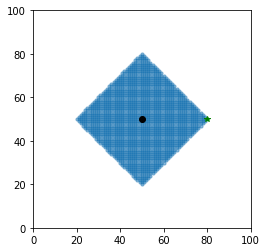

In [7]:
# define our visualization output & create it
VIS1 = VISUALIZATION(AUV1,ENV1)
VIS1.ShowReef()

# Plan the path and animate the search process
anim = AUV1.PlanPath(alg = "Dijkstra", cost=cost, heuristic=None, env = ENV1, vis=VIS1, alpha=0)
HTML(VIS1.searchAnimation.to_html5_video())

Note the difference in the exploration of the search space between A\* and Dijkstra. The A* planner uses its heuristic to quickly extend its search only in the direction of the goal. Because only a few nodes are explored, fewer calculations are needed and the runtime is relatively short. Dijkstra's algorithm, in contrast, searches uniformly throughout the environment through multiple paths simultaneously until the goal is found. Since more nodes are explored, this algorithm has a longer runtime. However, with our current simple environment, both will ultimately find the same path.

Now let's visualize the path we've found with our two algorithms above:

In [8]:
# Now show the AUV executing the mission
VIS1.video = VIS1.Explore()
HTML(VIS1.video.to_html5_video())

# 3.0 Mission 1: Volcano Water Sampling

With the path-planning algorithms tested in the swimming pool, the group is now confident to take on the challenge of the more realistic mission environment. The ORI provides the MERS group with a map of the mission site which shows the size of the allowable mission region and the depth of the reef at the mission site. For this mission, the AUV will operate at a constant depth of $9.5\text{m}$. The figure below shows the mission environment.

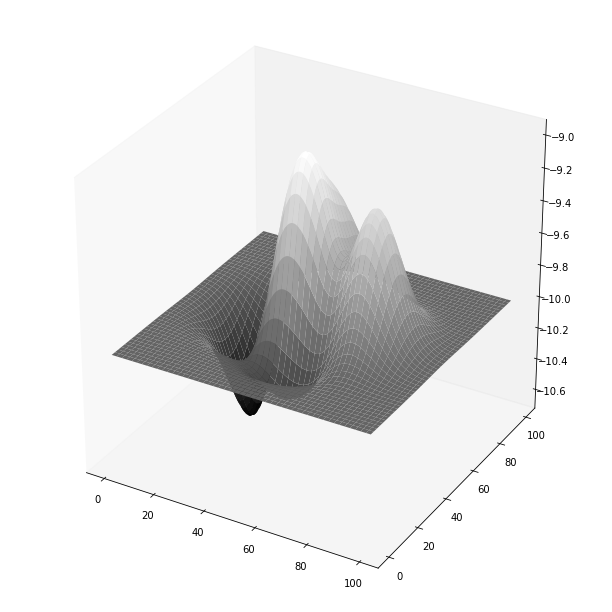

In [10]:
plt.rcParams['figure.figsize'] = [size+2, size+2]
InspectReefData3D()

## 3.1 Modeling Obstacles and risk in the environment
Clearly, at a depth of 9.5m the path planner will have to account for obstacles. We encode obstacles by assigning the maximum risk value of $1$ to every node in the in the obstacle's area. The risk corresponds to the probability of hazards to the mission at each point. While nodes inside an obstacle are assigned the maximum risk value of $1$, collision-free nodes are assigned a risk of $0$. 

To visualize the obstacles we create a new environment using a reef function built from the ORI data. We can then visualize the mission environment as before, using a contour plot to show the depth, and highlight the high risk obstacle nodes in red.

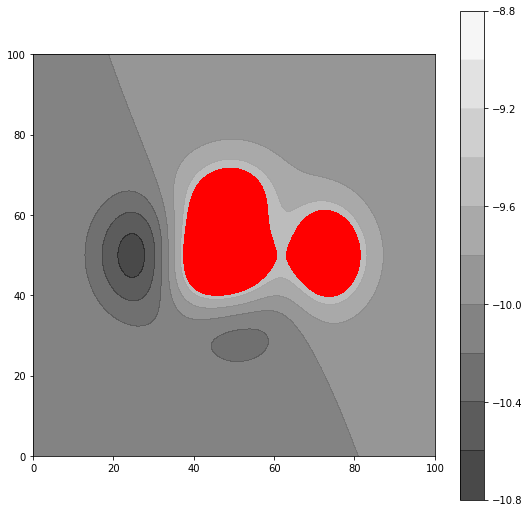

In [11]:
plt.rcParams['figure.figsize'] = [size, size]

ENV2 = ENVIRONMENT(UEXP, ReefFunction=None)
VIS2 = VISUALIZATION(AUV1,ENV2)
VIS2.ShowReef()
VIS2.ShowObstacles(-9.5)

In addition to the obstacles, the ORI has also warned the group that there are some areas that are especially risky due to geothermal activity, and that these areas should be avoided if possible. 

We encode these as additional risk regions in the environment. Each region is a polygon, defined by its corner locations. We provide that information to the environment object `ENV2` by passing a dictionary of corner coordinates keyed by each region's risk value via the `.UnknownRegions` attribute. A risk of 1 corresponds to certain mission failure and is treated just like an obstacle, whereas lower risk values are less likely to fail the mission.

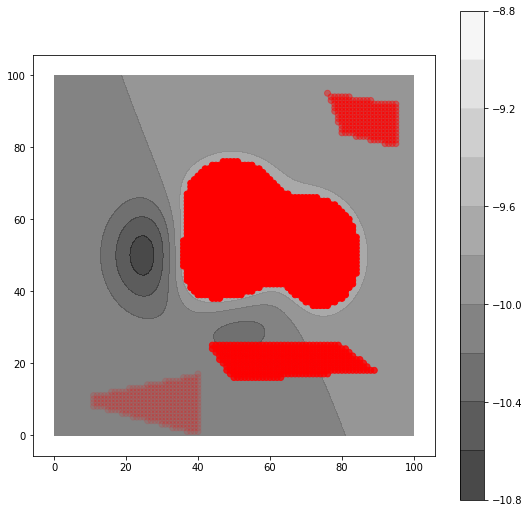

In [12]:
plt.rcParams['figure.figsize'] = [size, size]

ENV2 = ENVIRONMENT(UEXP, ReefFunction=None)

ENV2.UnknownRegions = { \
                       0.8: [(50, 15), (43, 25), (80, 25), (88, 19), (90,18)], \
                       0.4: [(80, 84), (95, 80), (95, 92), (76, 95)], \
                       0.1: [(11, 8), (40, 0), (40, 17), (11, 11)] \
                       }
ENV2.RiskField = ENV2.GenerateRiskField()

VIS2 = VISUALIZATION(AUV1,ENV2)
VIS2.ShowReef()
VIS2.ShowObstacles(-9.5)
VIS2.ShowRisk()
plt.show()
# VIS2.ShowObstacles(-9.5)
# plt.rcParams['figure.figsize'] = [size, size]
# InspectReefData2DComplete()

## 3.2 Accounting for risk in the path planners
We need to incorporate risk into our path planning heuristic, which currently only depends on the time cost $T$ it takes to reach the goal. Since the risk $R$ at each point has a value between 0 and 1, we will scale our cost by a function of $R$. The equation we used for our new heuristic cost is below:

$$H=T\bigg(\frac{1}{1-\alpha R + \epsilon}\bigg)$$

The higher the risk, the higher the heuristic cost. The $\epsilon$ is a very small number included to avoid division by 0.
## 3.3 Planning the mission
Now we can test our our local and global path planners using the new heuristic. We will send out our AUV on its first mission into the reef early in the morning, when the currents are calm enough to ignore.

In [15]:
AUV1.origin = (60, 10, -9.5)
AUV1.goal = (20, 20,-9.5)

AUV1.PlanPath(alg = "A*", cost = costwithrisk, heuristic = heuristicwithrisk, env = ENV2, vis=None,  alpha=0.9)
VIS2.video = VIS2.Explore()
HTML(VIS2.video.to_html5_video())

Cost map generated!
goal is found!


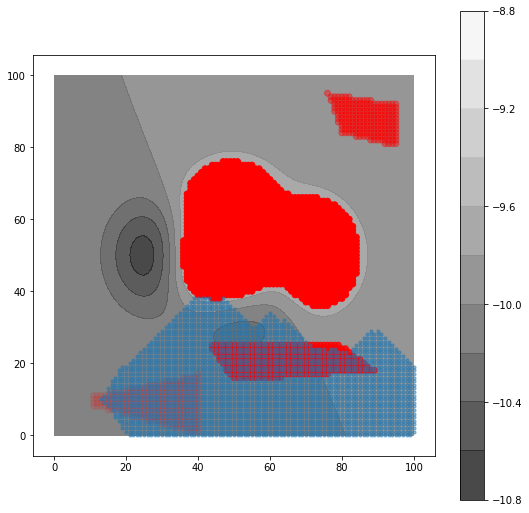

In [16]:
AUV1.origin = (60, 10, -9.5)
AUV1.goal = (20, 20,-9.5)
# define our visualization output & create it
VIS2 = VISUALIZATION(AUV1,ENV2)
VIS2.ShowReef()
VIS2.ShowObstacles(-9.5)
VIS2.ShowRisk()

# Plan the path and animate the search process
anim = AUV1.PlanPath(alg = "Dijkstra", cost = costwithrisk, heuristic = None, env = ENV2, vis=VIS2, alpha=0.9)
HTML(VIS2.searchAnimation.to_html5_video())

# 4.0 Mission 2: Endangered Shark Observation
## 4.1 Modeling ocean currents

In [17]:
AUV1.origin = (20, 50, -9.5)
AUV1.goal = (20, 50,-9.5)
ENV2.CurrentField_x, ENV2.CurrentField_y =  ENV2.GenerateCurrentField(type="uniformX", max_strength=1)

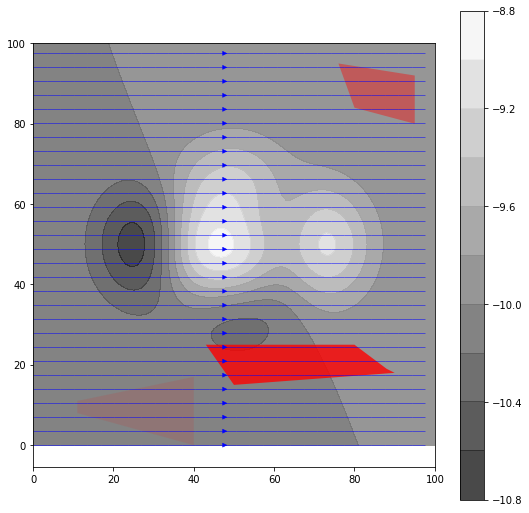

In [18]:
VIS2 = VISUALIZATION(AUV1,ENV2)
VIS2.ShowReef()
#VIS2.ShowObstacles()
VIS2.ShowUnknownRegions()
VIS2.ShowCurrent()

## 4.2 Incorporating currents in the path planner
We want to modify our time cost $T$ to include the effect of the local currents. Let's take a look at the current node and some neighboring node. Given the maximum speed of our AUV $||v_{AUV}||$, the current vector at the neighboring node $v_{current}$, the distance $d$ between the two nodes, and the unit vector $\hat{s}$ indicating the direction towards the goal, we can calculate:

$$T = \frac{d}{||v_{AUV}||+v_{current}\cdot\hat{s}}$$ 

The denominator gives us the combined speed that results from adding the perpendicular of $v_{current}$ to the AUV's base speed, so the overall equation provides us with the time cost of reaching the neighboring node in terms of how much closer it will bring us to the direction of our goal.

## 4.3 Executing the mission
Now we can send the AUV out into the reef and test out how well it navigates through the stronger currents.

In [ ]:
AUV1.origin = (60, 10, -9.5)
AUV1.goal = (90, 50,-9.5)

AUV1.PlanPath(alg = "A*", env = ENV2, vis=VIS2,  alpha=1)
VIS2.video = VIS2.Explore()
HTML(VIS2.video.to_html5_video())

Right before finishing their last mission and pulling the AUV back onto the boat a person from a big yacht nearby desperately begs for help: Enjoying the sun on the roof deck of her ship the diamond on her ring fell off and into the water. She is very upset to find it and as the MERS group happens to be in the area they offer their support in finding the diamond and do a third mission. 

# 5.0 Mission 3: Deep Water Recovery
As the group nears the end of their mission, they retrieve and begin recharging the AUV, whose battery is running low. However, a crew member requests that the AUV visit one last area of interest which could provide valuable data. This is a risky undertaking as the MERS group knows that at this late time of the day, the currents will probably have built up into strong circular whirlpool currents. In order for the AUV to navigate back to the boat, the planning will not only have to take into account obstacles, unknown regions, and the currents but also the uncertainty that related to the underwater map of the reef that they were given. The mission scenario is visualized below:
![](mission3.png) <br>
<font color='green'>[DEVELOP STEP BY STEP HERE]</font>

As the MERS group has just conducted two missions, will still have the models for the environment and the AUV loaded on their devices. While the AUV is still charging, they can go ahead and extend their models by the circular currents. At the moment, the model of the environment still contains the uniform current field defined from the previous mission. Now let's update the environment model to the circular current field by using the `GenerateCurrentField` method provided in the `ENVIRONMENT` class and passing the argument `type="whirlpool"`:

In [ ]:
# update the current in the environment model
ENV1.CurrentField_x, ENV1.CurrentField_y = ENV1.GenerateCurrentField(type="whirlpool", max_strength=1)

Let's see what our environment looks like when we use the circular current model. Just like we did above we visualize our scenario by creating a visualization instance and then calling its methods `.ShowReef()`, `.ShowCurrent()`, and `.ShowUnknownRegions()` to show the reef, the current, and the unknown regions.

In [ ]:
plt.rcParams['figure.figsize'] = [size, size]
# define our visualization output & create it
VIS1 = VISUALIZATION(AUV1,ENV1)
VIS1.ShowReef()
##
VIS1.ShowObstacles(-9.5)
##
VIS1.ShowCurrent()
VIS1.ShowUnknownRegions()

After realizing the strength of the circular currents, the MERS group decides to be more careful and choose a more conservative approach to risk. In order to be safe and prevent losing their very expensive AUV, a member of the team comes up with the idea of blurring the risk around obstacles and unknown regions. The `ENVIRONMENT` class that we have been using so far fortunately provides an interfaces for such an approach. Let's now use that interface and blur the risk. <br>
So far our environment model assumes the risk regions and obstacle locations we are given are accurate. As we want to move away from that idea and blur those regions we first need to tell our environmental model that we want to do so by calling `ENV1.Blur()`. Now we can visualize our scenario with blurred risk:

In [ ]:
plt.rcParams['figure.figsize'] = [size, size]
ENV1.Blur()
VIS1 = VISUALIZATION(AUV1,ENV1)
VIS1.ShowReef()
VIS1.ShowCurrent()
VIS1.ShowUnknownRegions()
VIS1.showRisk()

As can be seen in the figure above, blurring the risk wraps the hazard areas (obstacle and the unknown regions) in a safety zone of lower risk. Given the utility function that takes into account risk (we will develop that function in the next paragraph), there is an incentive for our AUV to avoid those regions and, hence, not rely on the accuracy of our underwater model as much. <br>
<br>
Now that the model is set up all the MERS group needs to plan their mission is an appropriate path planning algorithm. As in this mission the planning needs to be as accurate as possible we should choose an algorithm that allows for global planning, namely, planning with a heuristic that takes into account the currents and distances at all the points up until the goal rather than just at surrounding points.
# 6.0 Path planning algorithm for more realistic environments
- develop & explain algorithm (maybe with pseudocode)
- apply it to the more realistic problem
- discuss the differences, advantages, disadvantages, etc., energy savings

The developed algorithm is passed to the `.PlanPath` method of the `AUV` class.  Therefore, we pass `alg="Dijkstra"` as an argument to the path planning method. Besides we have to map the planning to an environment, a visualization, and specify a weight factor `alpha` for balancing the importance of _risk_ versus _energy efficiency_. `alpha` takes on a value between $0$ and $1$ where zero means that risk is not taken into account (so taking a path through a region where we expect an obstacle is allowed) and `alpha=1` gives risk the absolute priority (taking a path through a highly risky region, either unknown or expected obstacle, not allowed). We pass all the mentioned parameters to the path planner and which in turn returns a path. We visualize this path by animating the AUV on its exploration mission. The animation is generated by calling `VIS1.Explore()` and assigning the resulting animation to `VIS1.video`:
<font color='red'>[Say that also search is done]</font>

In [ ]:
# provide remainder of necessary information and initiate path planning
AUV1.PlanPath(alg = "Dijkstra", env = ENV1, vis=VIS1,  alpha=1)

# generate the animation
VIS1.video = VIS1.Explore()

In [ ]:
HTML(VIS1.video.to_html5_video())

# 7.0 Additional algorithmic approaches (potential short response section)
### 7.1 Any-angle
What might be advantages of applying an any-angle algorithm (such as Theta\*) to this problem? What might be a disadvantage? (Think about the effect of current field on the path planning.)

WRITE YOUR ANSWER HERE

### 7.2 Post-smoothing
We discussed the idea of smoothing the path returned by a non angle-angle algorithm, such as A\*. When might we run into issues with post-smoothing?

WRITE YOUR ANSWER HERE

### 7.3 D\*/D\* Lite (if we don't implement D\*)
What is the benefit of using a D\* approach to this problem? Might this backfire if the sensors recieve a lot of noise? If so, how might we solve this problem?

WRITE YOUR ANSWER HERE (introduce probablistic approach)

## Sources
<font color='red'>[Format examples]</font> <br>
<br>
[9] Jennifer Boger et al., “A Planning System Based on Markov Decision Processes to Guide People with Dementia Through Activities of Daily Living“. In: IEEE Transactions on Information Technology in Biomedicine, 2006, p. 323 – 333 <br>
[10] Michael L. Littman, “Markov games as a framework for multi-agent reinforcement learning”. In: Proceedings of the Eleventh International Conference on Machine Learning, 1994, p. 157 – 163 <br>